### Centroid_test_profile

This script reads a profile exported by Global Mapper, running from land -> ocean. Volumes and volume centroids are calculated two ways:

* Profiles are clipped to seaward extent of shorted profiles, then missing data is replaced with the September fill surface intepolated by Andy.

* Profiles are extended downward using the last two points after missing data is replaced with the September fill surface.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

import pandas as pd

from scipy import interpolate, signal, stats

%matplotlib inline

In [2]:
df=pd.read_csv("D:\\crs\\proj\\2019_DorianOBX\\WayneWright_flights\\CoreBx\\test_profile.csv",header = 0)
#print(df)
print("Read: ",len(df.index),' lines.')
df

Read:  1024  lines.


,ID,X,Y,Elevation,Elevation (Fill_2019091213_EBK_linear_1m.tif),Elevation (2019-08-30_1m_DEM_4D_crop2.tif),Elevation (2019-09-12-13_1mDEM_4D_v3.tif),Elevation (2019-10-11_1m_DEM_4D_crop.tif),Elevation (2019-11-26_1m_DEM_4D_crop.tif),Distance (Segment),Distance (Total),Distance 3D (Segment),Distance 3D (Total),Slope (Degrees),Slope (Percent),Segment Index
0,1,392586.480,3870008.949,5.618,3.922,5.782,5.465,5.853,5.618,0.0000,0.0000,0.0000,0.0000,-,-,1
1,2,392586.761,3870008.637,5.424,3.917,5.487,5.195,5.414,5.424,0.4201,0.4201,0.4627,0.4627,24.8,46.2%,1
2,3,392587.041,3870008.324,5.259,3.911,5.235,5.026,5.152,5.259,0.4201,0.8400,0.4511,0.9140,21.4,39.1%,1
3,4,392587.322,3870008.012,5.016,3.901,4.936,4.835,4.866,5.016,0.4201,1.2600,0.4854,1.3990,30.0,57.8%,1
4,5,392587.603,3870007.700,4.706,3.891,4.559,4.622,4.466,4.706,0.4201,1.6810,0.5220,1.9210,36.4,73.8%,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1019,1020,392872.479,3869690.528,0.870,NaN,NaN,NaN,NaN,NaN,0.4201,428.1100,0.4201,442.5900,0.0,0.0%,1
1020,1021,392872.760,3869690.215,0.870,NaN,NaN,NaN,NaN,NaN,0.4201,428.5300,0.4201,443.0100,0.0,0.0%,1
1021,1022,392873.040,3869689.903,0.870,NaN,NaN,NaN,NaN,NaN,0.4201,428.9500,0.4201,443.4300,0.0,0.0%,1
1022,1023,392873.321,3869689.590,0.870,NaN,NaN,NaN,NaN,NaN,0.4201,429.3700,0.4201,443.8500,0.0,0.0%,1


In [3]:
nmaps = 4
dist = np.array(df['Distance (Total)'])
Aug = np.array(df['Elevation (2019-08-30_1m_DEM_4D_crop2.tif)'])
Sep = np.array(df['Elevation (2019-09-12-13_1mDEM_4D_v3.tif)'])
Oct = np.array(df['Elevation (2019-10-11_1m_DEM_4D_crop.tif)'])
Nov = np.array(df['Elevation (2019-11-26_1m_DEM_4D_crop.tif)'])
Sep_fill = np.array(df['Elevation (Fill_2019091213_EBK_linear_1m.tif)'])
dx = np.array(df['Distance (Segment)'])[1]
print('dx: ',dx)
#cols=['#fef0d9','#fdcc8a','#fc8d59','#d7301f']
cols=['#feedde','#fdbe85','#fd8d3c','#e6550d','#a63603']

profs = np.array([Aug,Sep,Oct,Nov])
nmaps,lp = np.shape(profs)
print("nmaps, length profiles: ",nmaps,lp)
pnames=['28-Aug','13-Sep','11-Oct','26-Nov']

print("Stack of profiles with shape: ",np.shape(profs))

dx:  0.4201
nmaps, length profiles:  4 1024
Stack of profiles with shape:  (4, 1024)


In [4]:
def centroid(x,z):
    cz = np.nanmean(z)
    cx = np.nansum(z*x)/np.nansum(z)
    return(cx,cz)

1024 790
Short arrays have shape:  (4, 790)
28-Aug
  Nans: 0 0
13-Sep
  Nans: 2 0
11-Oct
  Nans: 319 0
26-Nov
  Nans: 70 0


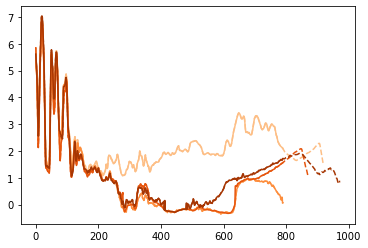

In [5]:
### Method 0 - Trim profiles to match shortest one
# this convoluted proceedure looks from the ocean side and finds the first good value in each profile
# the largest of these is associated with the shortest profile
#array of last good values
ii = np.ones((nmaps),dtype=np.int32)
for i in range(0,nmaps):
    ix=np.argwhere(np.isfinite(np.flip(profs[i,:])))
    ii[i]=int(ix[0]-1)

# index to end of shortest array
imx = np.max(ii)
ishort = lp-(imx+1)
print(lp,ishort)

# make clipped arrays
pshort = np.zeros((nmaps,ishort))
print("Short arrays have shape: ",np.shape(pshort))
dists = dist[0:ishort].copy()
Sep_fill_short = Sep_fill[0:ishort].copy()
for i in range(0,nmaps):
    pshort[i,:] = profs[i,0:ishort]

for i in range(0,nmaps):
    print(pnames[i])
    idx = np.argwhere(np.isnan(pshort[i,:]))
    pshort[i,idx]=Sep_fill_short[idx].copy()
    print('  Nans:', len(idx), np.sum(np.isnan(pshort[i,:])))

for i in range(0,nmaps):
    plt.plot(profs[i,:],'--',c=cols[i+1])
for i in range(0,nmaps):
    plt.plot(pshort[i,:],'-',c=cols[i+1])


In [6]:
### Method 1 - Replace any missing data with available Sep_fill and extend profiles
# replace missing data in Oct and Nov with Sep_fill
proff = profs.copy()
for i in range(0,nmaps):
    print(pnames[i])
    idx = np.argwhere(np.isnan(profs[i,:]))
    proff[i,idx]=Sep_fill[idx].copy()
    print('  Nans:', len(idx), np.sum(np.isnan(proff[i,:])))

28-Aug
  Nans: 105 105
13-Sep
  Nans: 236 105
11-Oct
  Nans: 471 105
26-Nov
  Nans: 121 51


In [ ]:
# extend profile using last two points
# (ilast is actually first nan)
profx = proff.copy()
for i in range(0,4):
    ilast = np.argwhere(np.isnan(proff[i,:]))[0]
    slp = (proff[i,ilast-1]-proff[i,ilast-2])/dx
    print(ilast,proff[i,ilast-1],proff[i,ilast-2],slp)
    if(slp<0):
        # extend profile
        profx[i,int(ilast):]=proff[i,int(ilast)-1]+slp*(dist[int(ilast):]-dist[int(ilast)-1])
    else:
        # fill end of profile with zeros
        profx[i,int(ilast):]=0.
        
# Or...fit to last 5 meters
profx2=proff.copy()
npts = int(5/dx)
for i in range(0,4):
    ilast = int(np.argwhere(np.isnan(proff[i,:]))[0])
    p = np.polyfit( dist[(ilast-npts-1):(ilast-1)], proff[i,(ilast-npts-1):(ilast-1)], 1)
    print(p)
    if(p[0]<0.):
        profx2[i,ilast:]=np.polyval(p,dist[ilast:])
    else:
        profx2[i,ilast]=0.

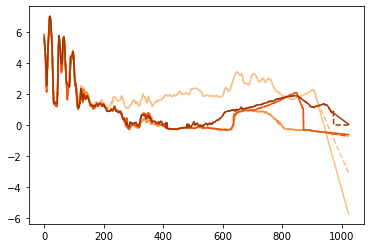

In [36]:
for i in range(0,nmaps):
    plt.plot(profx[i,:],'--',c=cols[i+1])
for i in range(0,nmaps):
    plt.plot(profx2[i,:],'-',c=cols[i+1])

In [37]:
# volumes for extended profiles
MLW=0.4
pMLW = profx2.copy()-MLW
pMLW[np.where(pMLW<=0.)]=0.
vMLW=np.sum(pMLW,1)*dx
print("Profile volumes: ", vMLW)

# volumes for clipped (short) profiles
pMLWs = pshort.copy()-MLW
pMLWs[np.where(pMLWs<=0.)]=0.
vMLWs=np.sum(pMLWs,1)*dx
print("Short profile volumes: ",vMLWs)

Profile volumes:  [713.0269079  247.2574168  301.413348   371.13219687]
Short profile volumes:  [628.3973428 247.2574168 254.5327086 285.5331479]


In [ ]:
# centroids for extended profiles
cxcy = np.zeros((4,2))
for i in range(0,4):
    cxcy[i,0],cxcy[i,1] = centroid(dist,proff[i,:])
print("Centroids: \n",cxcy)

# centroids for short profiles
cxcys = np.zeros((4,2))
for i in range(0,4):
    cxcy[i,0],cxcy[i,1] = centroid(dists,pshort[i,:])
print("Centroids: \n",cxcy)

In [ ]:
plt.plot(dist,np.ones_like(dist)*0.4,'--',c='dimgray',linewidth=2)
for i in range(0,4):
    plt.plot(dist,profs[i,:],'-',linewidth=3,c=cols[i+1],label=pnames[i])
    plt.plot(dist,proff[i,:],':',linewidth=3,c=cols[i+1])
for i in range(0,4):
    plt.plot(cxcy[i,0],cxcy[i,1],'ok',ms=12)
    plt.plot(cxcy[i,0],cxcy[i,1],'o',c=cols[i])

plt.legend()
plt.ylim((-1., 6.))
plt.ylabel('Elevation (m NAVD88)')
plt.xlabel('Across-shore Distance (m)')
plt.savefig('profile.svg')